In [2]:
model_name = 'article-bias-2'
from transformers import pipeline, AutoTokenizer, AutoModelForSequenceClassification
tokenizer = AutoTokenizer.from_pretrained(model_name)
pipe = pipeline("text-classification", model=model_name, tokenizer=tokenizer)
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=3,output_attentions=True)#.to("cuda")

In [9]:
def truncate_text(text, tokenizer, max_length=512):
    tokens = tokenizer.tokenize(text)
    truncated_tokens = tokens[:max_length - 2]  # Reserve space for special tokens [CLS] and [SEP]
    truncated_text = tokenizer.convert_tokens_to_string(truncated_tokens)
    return truncated_text

In [3]:
model.eval()

DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
 

In [4]:
import json
def load_article_json(name):
    with open(f'./data/jsons/{name}.json', 'r') as f:
        data = json.load(f)
        return data

In [5]:
article1 = load_article_json('I3B0cfqnYOw0R0Rp')
article1['bias'], article1['bias_text'], article1['title'], article1['source']

(2,
 'right',
 "PA Lawmaker's Bill Would Ban Teachers From Talking Politics in the Classroom",
 'Fox Online News')

In [10]:
text = truncate_text(article1['content'], tokenizer, max_length=500)
text

Token indices sequence length is longer than the specified maximum sequence length for this model (879 > 512). Running this sequence through the model will result in indexing errors


'a pennsylvania state lawmaker is pushing a bill that would ban schoolteachers from talking about modern - day civics, politics and public affairs in the classroom. state rep. will tallman ( r ), who is retiring at the end of the year, sent a memo to his colleagues in the state house last friday seeking support for what he has dubbed the “ teacher code of ethics. ” according to the memo, the bill would prohibit public elementary or secondary schoolteachers, while operating within the scope of their employment, from endorsing, supporting, or opposing any the following : - candidate or nominee for public office or any local, state, or federal official, regardless of whether such official is elected or appointed ; - local, state, or federal legislation or regulation, regardless of whether such legislation or regulation is pending, proposed, or enacted ; - local, state, or federal court case or judicial action, regardless of whether such court case or judicial action is pending, proposed, 

In [11]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

def aggregate_attentions(attentions):
    # Convert attentions to numpy arrays and stack layers
    attentions = np.stack([att.detach().cpu().numpy() for att in attentions])
    
    # Compute mean attentions across layers and heads
    mean_attentions = attentions.mean(axis=(0, 1))
    
    return mean_attentions

def plot_attention_heatmap(aggregated_attentions, input_ids, tokenizer):
    tokens = tokenizer.convert_ids_to_tokens(input_ids[0])
    plt.figure(figsize=(16, 5))
    sns.heatmap(aggregated_attentions, xticklabels=tokens, yticklabels=tokens)
    plt.show()
    
    
def compute_gradients(inputs, target_label):
    model.zero_grad()

    with torch.no_grad():
        embeddings = model.distilbert.embeddings(inputs["input_ids"])

    embeddings.requires_grad_(True)

    outputs = model(inputs_embeds=embeddings, attention_mask=inputs["attention_mask"])
    logits = outputs.logits
    target_label_tensor = torch.tensor([target_label], dtype=torch.long).to(logits.device)
    loss_fn = torch.nn.CrossEntropyLoss()
    loss = loss_fn(logits, target_label_tensor)
    loss.backward()

    return embeddings.grad
    
def visualize_gradients(gradients, input_ids, tokenizer, top_k=10):
    gradients = gradients.squeeze().abs().sum(dim=-1).cpu().numpy()
    tokens = tokenizer.convert_ids_to_tokens(input_ids[0])
    
    # Get the indices of the top-k influential tokens
    top_k_indices = gradients.argsort()[-top_k:][::-1]
    
    # Get the top-k tokens and their gradients
    top_k_tokens = [tokens[i] for i in top_k_indices]
    top_k_gradients = gradients[top_k_indices]
    
    plt.figure(figsize=(16, 5))
    sns.barplot(y=top_k_tokens, x=top_k_gradients, orient='h')
    plt.xticks(rotation=90)
    plt.show()
    
    
def visualize_ngrams_gradients(gradients, input_ids, tokenizer, n=2, top_k=10):
    gradients = gradients.squeeze().abs().sum(dim=-1).cpu().numpy()
    tokens = tokenizer.convert_ids_to_tokens(input_ids[0])
    
    # Aggregate gradients over n-grams
    ngrams_gradients = [gradients[i:i + n].sum() for i in range(len(gradients) - n + 1)]
    ngrams_tokens = [' '.join(tokens[i:i + n]) for i in range(len(tokens) - n + 1)]
    
    # Get the indices of the top-k influential n-grams
    top_k_indices = np.argsort(ngrams_gradients)[-top_k:][::-1]
    
    # Get the top-k n-grams and their gradients
    top_k_ngrams = [ngrams_tokens[i] for i in top_k_indices]
    top_k_ngrams_gradients = [ngrams_gradients[i] for i in top_k_indices]

    plt.figure(figsize=(16, 5))
    sns.barplot(y=top_k_ngrams, x=top_k_ngrams_gradients, orient='h')
    plt.xticks(rotation=90)
    plt.show()

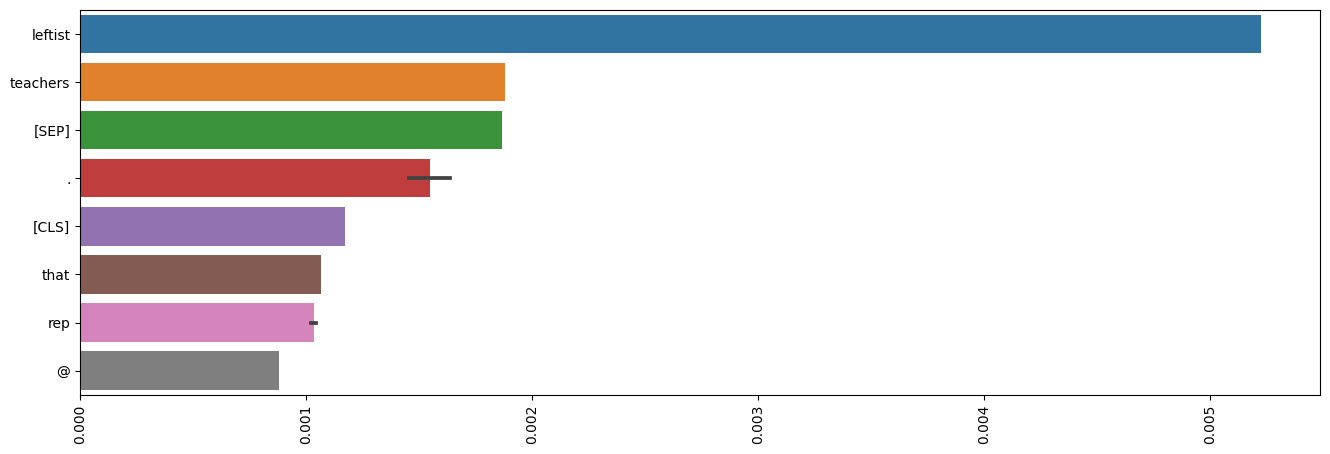

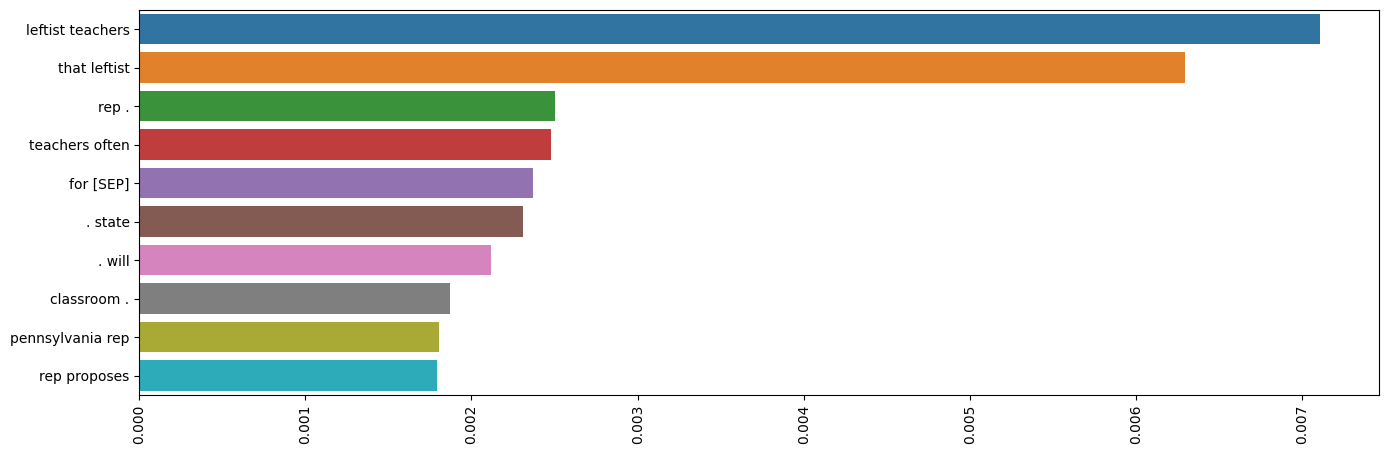

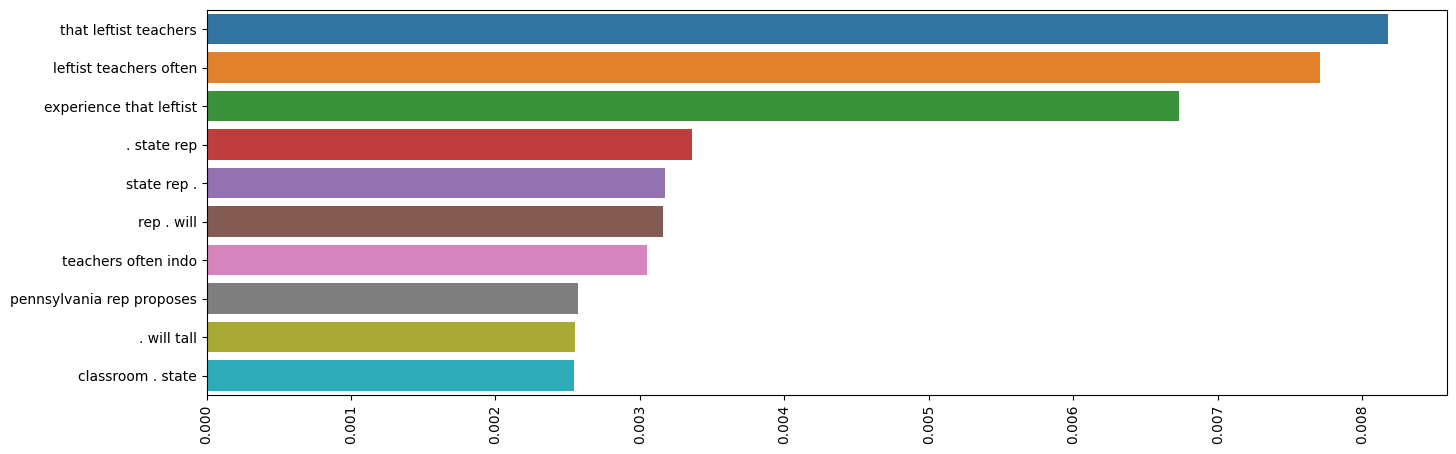

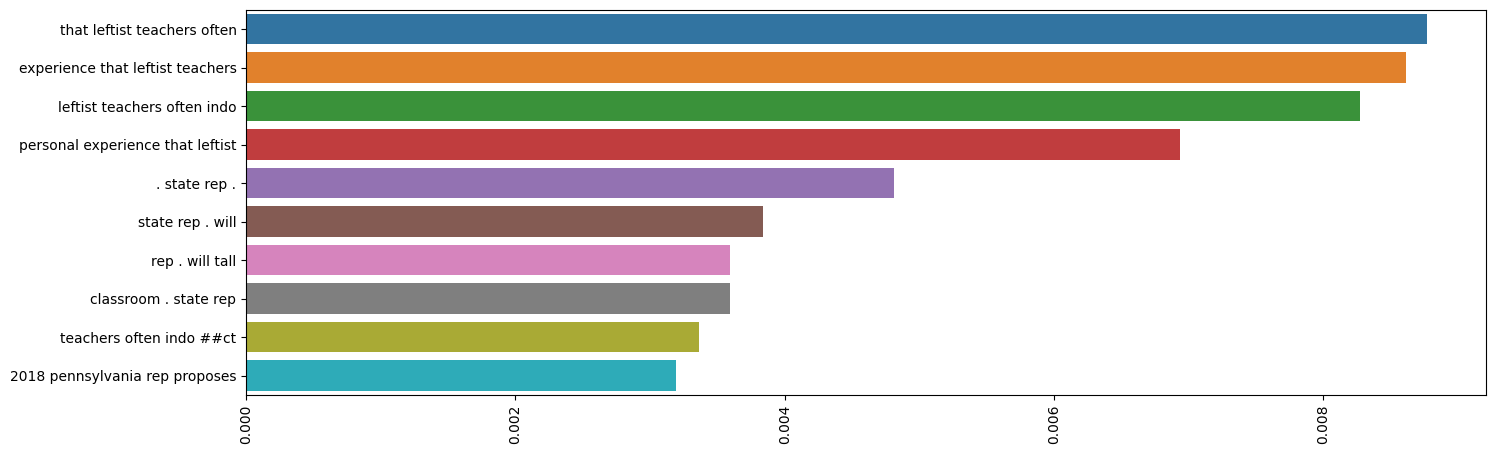

In [12]:
import torch

model.eval()
for param in model.parameters():
    param.requires_grad = True


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Move the model to the device
model = model.to(device)


# Tokenize input and convert to tensors
inputs = tokenizer(text, return_tensors="pt", padding='max_length', max_length=500, truncation=True).to(model.device)

# # Move the inputs to the device
# for key, value in inputs.items():
#     inputs[key] = value.to(device)

gradients = compute_gradients(inputs, target_label=2)
visualize_gradients(gradients, inputs['input_ids'], tokenizer)
visualize_ngrams_gradients(gradients, inputs['input_ids'], tokenizer)
visualize_ngrams_gradients(gradients, inputs['input_ids'], tokenizer, n=3)
visualize_ngrams_gradients(gradients, inputs['input_ids'], tokenizer, n=4)

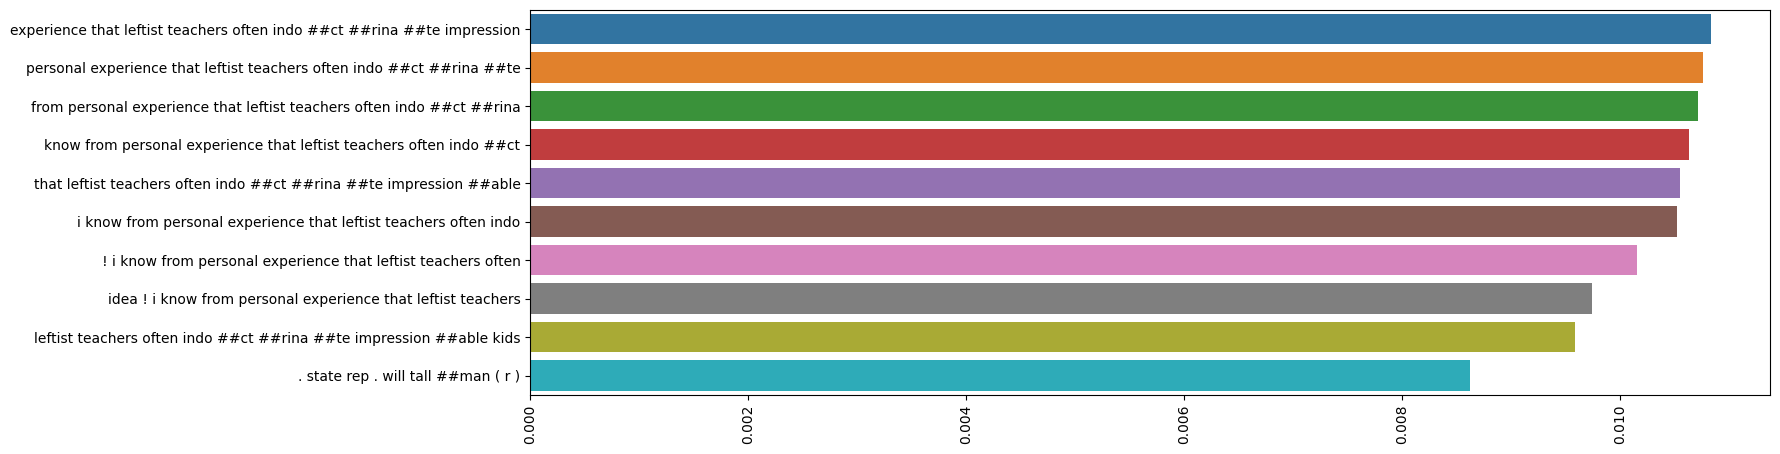

In [13]:
visualize_ngrams_gradients(gradients, inputs['input_ids'], tokenizer, n=10)